#BRAIN TUMOR LOCALIZATION

##Details:

*   Number of Brain MRI scan: 3929
*   Data Source: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

##Steps Involved:

*   Input: MRI scan.
*   First Phase: Detect Tumor using Resnet Classifier Model.
*   Second Phase: If tumor is present, using ResUnet model to localize the tumor on pixel level.
*   Third Phase: Send the output image in JSON format.


#Brain Tumor Classification

##Import Libraries and Datasets

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import random
from skimage import io
import tensorflow as tf
import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import glob
import random
from google.colab import files
%matplotlib inline
print('Keras Version:', keras.__version__)
print('TenserFlow Version:', tf.__version__)

Keras Version: 2.4.3
TenserFlow Version: 2.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/Datasets/Brain Tumor Localization/Brain MRI Scan/'

/content/drive/My Drive/Datasets/Brain Tumor Localization/Brain MRI Scan


In [ ]:
ls

In [ ]:
brain_df = pd.read_csv('data_mask.csv')

##Data Visualization

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df.shape

(3929, 4)

In [ ]:
brain_df.head(20)

In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

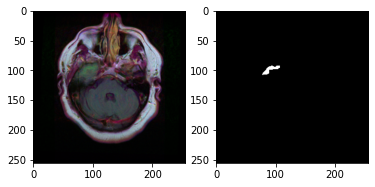

In [ ]:
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.image_path[623]))
plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.mask_path[623]))

In [ ]:
print('Max Pixel:',cv2.imread(brain_df.mask_path[623]).max())
print('Min Pixel:', cv2.imread(brain_df.mask_path[623]).min())

Max Pixel: 255
Min Pixel: 0


In [ ]:
# Image Dimension
cv2.imread(brain_df.mask_path[623]).shape

(256, 256, 3)

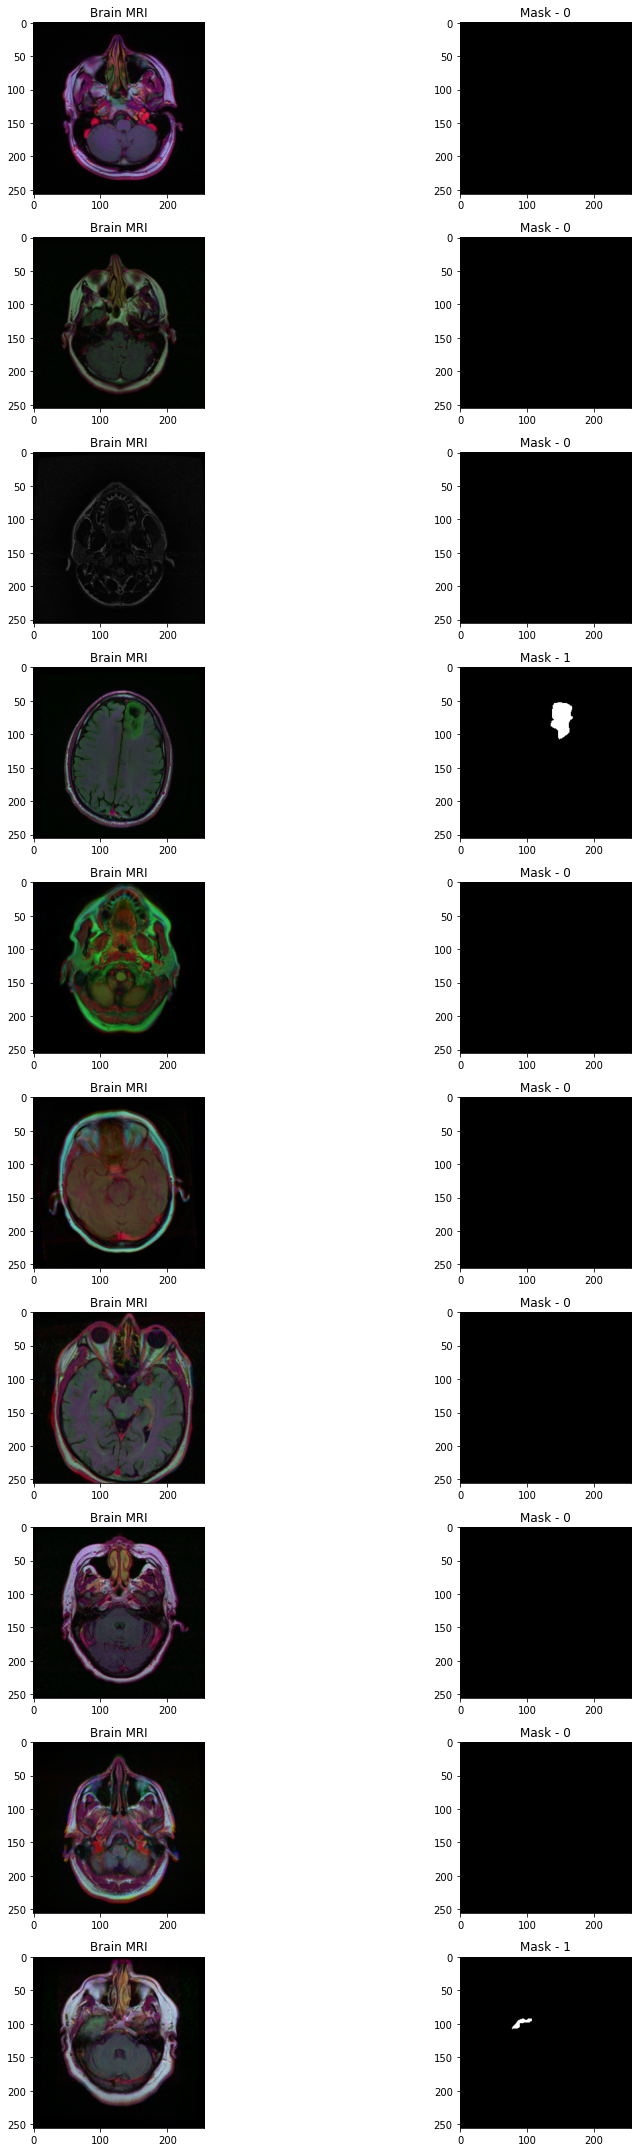

In [ ]:
fig, axs = plt.subplots(10,2, figsize=(15,30))
count = 0
for x in range(10):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

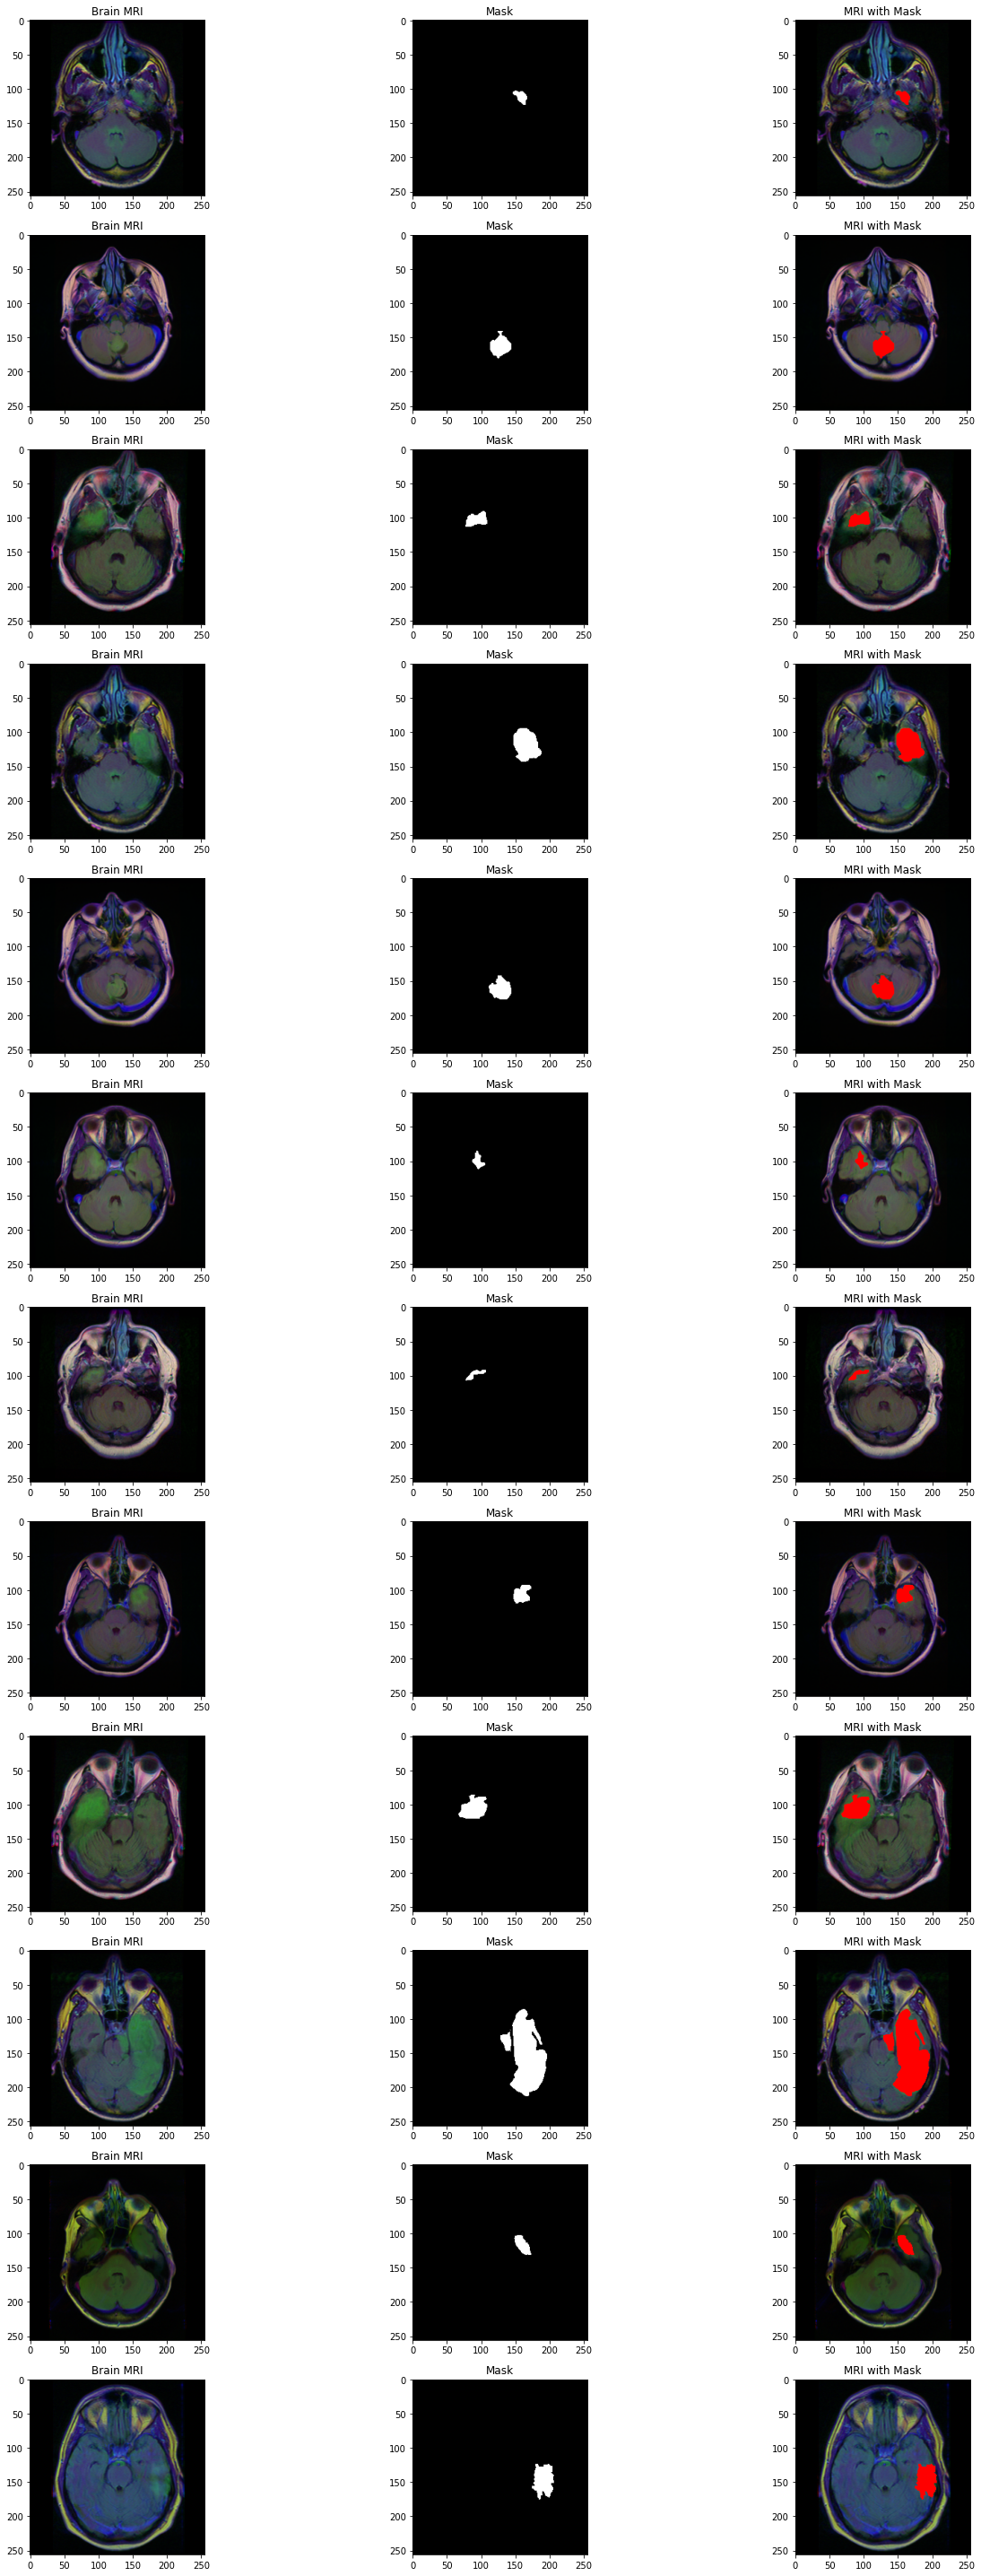

In [ ]:
#Visualizing the brain MRI scan with 
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 40))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask - 1')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

## Data Preparation

In [ ]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
# Convert mask field to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# split the data into train and test data

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split = 0.15)

train_generator=datagen.flow_from_dataframe(
dataframe=train,          # train - It is dataframe
directory= './',          # directory - pointing the current directory
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [ ]:
# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1.0/255.0)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 590 validated image filenames belonging to 2 classes.


## Training a Resnet Classifier Model

In [ ]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

In [ ]:
# freeze the model weights
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

In [ ]:
# compile the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
print('Total number of data in training set',train_generator.n)
print('Total number of data in validation set', valid_generator.n)

Total number of data in training set 2839
Total number of data in validation set 500


In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 15, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/15
177/177 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.7138 
Epoch 00001: val_loss improved from inf to 113.96673, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 2487s 14s/step - loss: 0.6775 - accuracy: 0.7138 - val_loss: 113.9667 - val_accuracy: 0.6371
Epoch 2/15
177/177 [==============================] - ETA: 0s - loss: 0.4352 - accuracy: 0.8091 
Epoch 00002: val_loss improved from 113.96673 to 0.66085, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 2418s 14s/step - loss: 0.4352 - accuracy: 0.8091 - val_loss: 0.6608 - val_accuracy: 0.6351
Epoch 3/15
177/177 [==============================] - ETA: 0s - loss: 0.4182 - accuracy: 0.8222 
Epoch 00003: val_loss did not improve from 0.66085
177/177 [==============================] - 2437s 14s/step - loss: 0.4182 - accuracy: 0.8222 - val_loss: 1.2389 - val_accuracy: 0.6411
Epoch 4/15
177/177 [============================

In [ ]:
history.history

In [ ]:
print(history.history.keys())

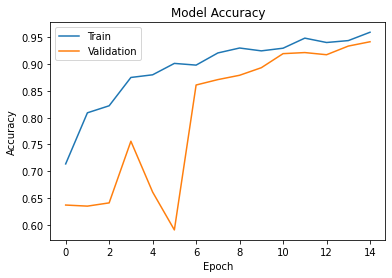

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

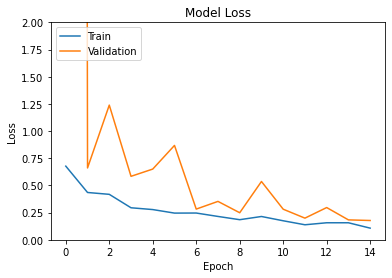

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim((0,2))
plt.show()

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

##Assess the trained model

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# make prediction

test_predict = model.predict(test_generator, steps = None, verbose =1)

37/37 [==============================] - 155s 4s/step


In [ ]:
test_predict.shape

(590, 2)

In [ ]:
test_predict

array([[1.00000000e+00, 1.87980326e-10],
       [1.00000000e+00, 1.09670543e-10],
       [9.99999404e-01, 5.83562041e-07],
       ...,
       [2.10229302e-07, 9.99999762e-01],
       [1.00000000e+00, 1.85550011e-08],
       [1.00000000e+00, 4.43731746e-10]], dtype=float32)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

print(predict)

['1' '1' '0' '0' '1' '1' '1' '1' '0' '1' '0' '0' '0' '1' '0' '0' '1' '1'
 '0' '0' '1' '0' '0' '0' '1' '1' '1' '0' '0' '0' '0' '0' '0' '0' '0' '1'
 '0' '0' '1' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1' '0'
 '1' '0' '0' '0' '0' '1' '0' '1' '0' '1' '0' '0' '0' '1' '0' '1' '0' '0'
 '1' '1' '0' '1' '0' '1' '1' '1' '0' '1' '0' '0' '1' '0' '1' '0' '0' '0'
 '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '0' '1' '0' '0' '0'
 '0' '1' '0' '1' '1' '0' '1' '0' '0' '0' '0' '0' '1' '0' '0' '0' '1' '0'
 '0' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '0' '0' '1' '0' '1'
 '1' '1' '1' '0' '1' '0' '1' '0' '1' '1' '0' '0' '0' '0' '0' '1' '1' '0'
 '1' '1' '0' '0' '1' '0' '1' '0' '0' '1' '0' '0' '0' '1' '0' '1' '0' '0'
 '0' '1' '1' '1' '0' '0' '0' '0' '1' '0' '1' '1' '0' '0' '0' '0' '1' '1'
 '0' '0' '0' '0' '0' '0' '1' '0' '0' '0' '1' '1' '0' '0' '1' '1' '0' '1'
 '1' '0' '0' '0' '0' '0' '1' '0' '0' '0' '0' '1' '0' '0' '1' '0' '0' '0'
 '0' '1' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1

In [ ]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

590

In [ ]:
# Obtain the accuracy of the model

accuracy = accuracy_score(original, predict)
accuracy

0.9847457627118644

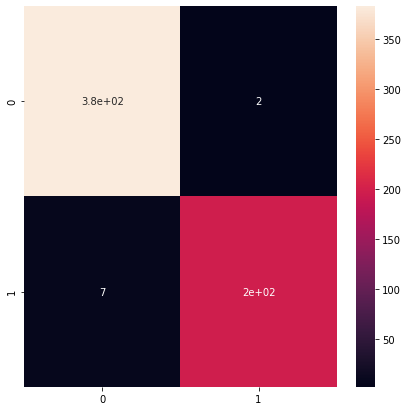

In [ ]:
# plot the confusion matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
# Classification Report

target_names = ['Mask - 0', 'Mask - 1']
print('Confusion Matrix:')
print(cm)
print('\nClassification Report:')
print(classification_report(original, predict, target_names=target_names))
print('Accuracy:', accuracy)

Confusion Matrix:
[[383   2]
 [  7 198]]

Classification Report:
              precision    recall  f1-score   support

    Mask - 0       0.98      0.99      0.99       385
    Mask - 1       0.99      0.97      0.98       205

    accuracy                           0.98       590
   macro avg       0.99      0.98      0.98       590
weighted avg       0.98      0.98      0.98       590

Accuracy: 0.9847457627118644


# Explainable AI

For this method, the Grad CAM is the one of the best method to perform explainablity. Here I tried to use two libraries.

## Grad CAM using tf-explain

In [ ]:
!pip install tf-explain

     |████████████████████████████████| 51kB 7.0MB/s 


In [ ]:
from tf_explain.core.grad_cam import GradCAM

In [ ]:
explainer = GradCAM()

## Grad CAM using vis library

In [ ]:
!pip install scipy==1.2.*

In [ ]:
!pip install keras==2.2.2
!pip install tensorflow==1.10.0

In [ ]:
!pip install Pillow

In [ ]:
import matplotlib.cm as cm
import vis
from vis.utils import utils
from vis.visualization import visualize_cam, overlay

ImportError: ignored

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
modelxai = tf.keras.models.model_from_json(json_savedModel)
modelxai.load_weights('weights.hdf5')
modelxai.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
modelxai.summary()

In [ ]:
print('Last layer name:',modelxai.layers[-1].name)

Last layer name: dense_5


In [ ]:

layer_idx = utils.find_layer_idx(modelxai, 'dense_5')

#swap softmax activation function with linear
modelxai.layers[layer_idx].activation = keras.activation.linear
modelxai = utils.apply_modifications(modelxai)

In [ ]:

penultimate_layer_idx = utils.find_layer_idx(modelxai, "conv5_block3_out") 
class_idx  = '1'
seed_input = img
grad_top1  = visualize_cam(modelxai, layer_idx, class_idx, seed_input, 
                           penultimate_layer_idx = penultimate_layer_idx,#None,
                           backprop_modifier     = None,
                           grad_modifier         = None)

#Brain Tumor Segmantation

## Data Preparation

In [ ]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
brain_df_mask.head()

,patient_id,image_path,mask_path,mask
445,TCGA_DU_5872_19950223,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...,1
507,TCGA_DU_5874_19950510,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...,1
551,TCGA_DU_5854_19951104,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...,1
555,TCGA_DU_5854_19951104,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...,1
617,TCGA_DU_5853_19950823,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...,1


In [ ]:
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

## Designing a Segmentation model

In [ ]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path or Identical Path

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
model_seg.summary()

## Train a model

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

In [ ]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

## Eval the model

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred.head(10)

,image_path,predicted_mask,has_mask
0,TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_37...,No mask,0
1,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_83...,No mask,0
2,TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_38...,No mask,0
3,TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_18...,No mask,0
4,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_56...,No mask,0
5,TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_11...,No mask,0
6,TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_14...,"[[[[6.737105e-07], [2.5930035e-06], [5.9117624...",1
7,TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_34...,No mask,0
8,TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_9.tif,"[[[[7.1147485e-07], [3.1334555e-06], [8.857045...",1
9,TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_15...,No mask,0


In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_37...,TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_37...,0,No mask,0
1,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_83...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_83...,0,No mask,0
2,TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_38...,TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_38...,0,No mask,0
3,TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_18...,TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_18...,0,No mask,0
4,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_56...,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_56...,0,No mask,0


In [ ]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

# Checking w.r to single MRI scan image

In [ ]:
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# Convert mask field to string format, to use categorical mode in flow_from_dataframe
brain_df['mask'] = brain_df['mask'].apply(lambda x: str(x))
brain_df = brain_df.drop(columns=['patient_id'])

In [ ]:
brain_df_mask0 = brain_df[brain_df['mask'] == '0']
brain_df_mask0.head()

,image_path,mask_path,mask
0,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [ ]:
brain_df_mask1 = brain_df[brain_df['mask'] == '1']
brain_df_mask1.head()

,image_path,mask_path,mask
445,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...,1
507,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...,1
551,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...,1
555,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...,1
617,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...,1


In [ ]:
directory = "./"
print(brain_df_mask1.image_path[445])
img1_path = directory + str(brain_df_mask1.image_path[445])
print('Image with Mask 1 file path:', img1_path)

TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif
Image with Mask 1 file path: ./TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif


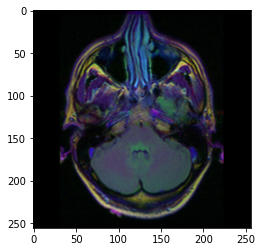

In [ ]:
img1 = io.imread(img1_path)

# Show image
plt.imshow(img1)

#Normalization
img1 = img1 * 1./255.

#Reshaping 
img1 = cv2.resize(img1, (256,256))

#Convert image into numpy array
img1 = np.array(img1, dtype = np.float64)

#Increasing a dimension
img1 = np.reshape(img1, (1,256,256,3))

# print(img1)

In [ ]:
stage1 = model.predict(img1)
print(stage1)

[[6.9158995e-07 9.9999928e-01]]


In [ ]:
img1 = io.imread(img1_path)

#Reshaping and Converting to array
img1 = cv2.resize(img1, (256,256))
img1 = np.array(img1, dtype = np.float64)

#standardising the image
img1 -= img1.mean()
img1 /= img1.std()

#Increasing a dimension
img1 = np.reshape(img1, (1,256,256,3))

stage2 = model_seg.predict(img1)
print(stage2)

In [ ]:
stage2.round().astype(int).sum() == 0

False

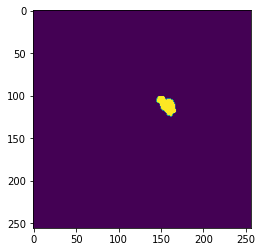

In [ ]:
stage2 = np.asarray(stage2)[0].squeeze().round()
plt.imshow(stage2)

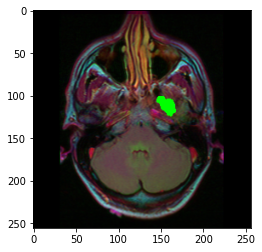

In [ ]:
img1 = io.imread(img1_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1[stage2 == 1] = (0, 255, 0)
plt.imshow(img1)